# PRÁCTICA 11: REDES NEURONALES DE FUNCIONES DE BASE RADIAL Y MÁQUINAS DE VECTORES SOPORTE

###### Técnicas de Aprendizaje Automático 2019/2020 <br>Patricia Aguado Labrador

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score as ac

from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.svm import SVC

import numpy as np
from scipy.stats import mode
import matplotlib.pyplot as plt

#### Descripción del conjunto de datos:

El conjunto de datos 'breast_cancer' está formado por características calculadas a partir de una imagen digitalizada de una biopsia del seno. Este dataset contiene 30 características de tipo numérico acerca de los núcleos celulares presentes en la imagen. Los datos pertenecen a una clase binaria, 0 si el diagnóstico es maligno y 1 si es benigno.

In [2]:
data = load_breast_cancer()

In [3]:
# Normalizar
X = MinMaxScaler().fit_transform(data.data)
y = data.target

X.shape, y.shape

((569, 30), (569,))

Las redes de función de base radial están formadas por tres capas: una de entrada, una única capa oculta y una capa de salida. El primer parámetro que hay que decidir es el número de neuronas que habrá en la capa oculta y que se encargarán de realizar determinados cálculos. Para entrenar la capa oculta utilizaremos el algoritmo k-medias y para ello necesitamos el número de clusters, el cual coincidirá con el número de neuronas, por lo que debemos de buscar el número de neuronas óptimo. Para encontrar este número aplicaremos el algoritmo k-medias variando k hasta encontrar el que mayor tasa de acierto nos ofrezca.

### TASAS DE ACIERTO PARA CADA POSIBLE NÚMERO DE NEURONAS EN LA CAPA OCULTA

In [4]:
# Creación de 10 particiones para realizar validación cruzada
skf = StratifiedKFold(n_splits=10, random_state=0)

Nº Clusters     Tasa de acierto
     2       |      0.9265
     3       |      0.9052
     4       |      0.8804
     5       |      0.9175
     6       |      0.8860
     7       |      0.8981
     8       |      0.9122
     9       |      0.9156
     10      |      0.9297
     11      |      0.9278
     12      |      0.9278
     13      |      0.9332
     14      |      0.9435
     15      |      0.9491
     16      |      0.9421
     17      |      0.9439
     18      |      0.9421
     19      |      0.9578
     20      |      0.9509
     21      |      0.9455
     22      |      0.9525
     23      |      0.9507
     24      |      0.9473
     25      |      0.9543
     26      |      0.9577
     27      |      0.9455
     28      |      0.9404
     29      |      0.9527
     30      |      0.9420


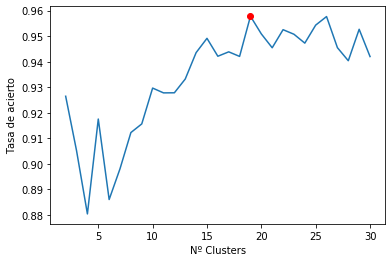

In [5]:
# Array que almacenará el número de clusters con el que obtuvimos la mayor tasa de acierto para
# cada tamaño de capa oculta que va a variar de 2 a 30
min_hl_size = 2
max_hl_size = 30
# Array para almacenar los resultados de la tasa de acierto por tamaño de capa oculta
hl_accuracy = np.zeros(max_hl_size-1, dtype='float')

print("\33[4mNº Clusters     Tasa de acierto\33[0m")

for hl in range(min_hl_size,max_hl_size+1):
    # Creación del agrupamiento de kmedias con un número de clusters igual al número de neuronas que varia de 2 a 30
    kmeans = KMeans(n_clusters=hl, random_state=0)
    
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Entrenamiento de kmeans en la partición
        kmeans.fit(X_train)
        # Array para almacenar el etiquedado de moda de los clusters existentes en cada partición
        mode_fold = np.ones(hl, dtype='int')
        
        for c in range(hl):
            # Número de clusters como número de neuronas
            cluster_labels = kmeans.labels_
            # Moda para cada cluster
            mode_fold[c] = mode(y_train[np.argwhere(cluster_labels == c)])[0]
        
        # Predecimos el cluster al que van a pertenecer las instancias de prueba
        cluster_predict = kmeans.predict(X_test)
        # Etiquetamos cada instancia con la moda del cluster al que pertenecen
        y_test_predict = mode_fold[cluster_predict]
        
        # Suma de las 10 tasas de acierto para cada cluster
        hl_accuracy[hl-min_hl_size] += ac(y_test,y_test_predict)
    
    # Media de la tasa de aciertos para cada número de clusters
    hl_accuracy[hl-min_hl_size] /= 10
    
    # Impresión de los resultados
    if(hl<10):
        print("    ",hl,"      |      %.4f" %hl_accuracy[hl-min_hl_size])
    else:
        print("    ",hl,"     |      %.4f" %hl_accuracy[hl-min_hl_size])

        
y_plot = hl_accuracy
x_plot = [i+min_hl_size for i in range(y_plot.shape[0])]
plt.plot(x_plot,y_plot)
plt.plot(np.argmax(y_plot)+min_hl_size,y_plot[np.argmax(y_plot)],marker="o",color="r")
plt.xlabel("Nº Clusters")
plt.ylabel("Tasa de acierto")
plt.show()

### NÚMERO DE CLUSTERS ÓPTIMO

In [6]:
optimal_cluster = np.argmax(hl_accuracy)+min_hl_size

print("\n\033[1mLa mayor tasa de acierto la obtenemos con",optimal_cluster,"clusters \033[0m(%.4f)" %hl_accuracy[np.argmax(hl_accuracy)])


La mayor tasa de acierto la obtenemos con 19 clusters (0.9578)


Una vez encontrado el número de neuronas óptimo, realizaremos mediante el método de validación cruzada el entrenamiento de la rbf para ver cómo trabaja la red con los parámetros que hemos decidido. Como hemos dicho antes, la capa oculta la vamos a entrenar con el algoritmo k-medias y una vez hecho esto las neuronas de una rbf se encargarán de calcular la distancia euclídea entre los centroides de los clusters (obtenidos mediante el entrenamiento con k-medias) y la entrada. Sobre estas distancias se aplicará la función de base radial (sigma) con la que obtendremos una medida sobre cuando una instancia activa una neurona para que produzca una salida significativa.

Por último, para el entrenamiento de la capa de salida utilizaremos un algoritmo supervisado denominado máquinas de vectores de soporte utilizando un núcleo polinómico. Ahora lo que debemos encontrar es el grado de esta función polinómica que mejor funciona con la capa de salida. Para encontrar el grado óptimo utilizaremos el metodo ensayo y error variando el parámetro 'degree' de 1 a 5, ya que a partir de este último los resultados comienzan a empeorar.

### RBF CON SVM EN LA CAPA DE SALIDA CON FUNCIÓN DE NÚCLEO POLINÓMICA

In [7]:
min_degree = 1
max_degree = 5
# Array para almacenar los resultados de la tasa de acierto por cada posible grado de función polinómica
accuracy_per_degree = np.zeros(max_degree, dtype='float')

print("\33[4mGrado polinomial     Tasa de acierto\33[0m")
for degree in range(min_degree, max_degree+1):
    
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Creación del agrupamiento de kmedias con el número de clusters óptimo anteriormente calculado
        kmeans = KMeans(n_clusters=optimal_cluster, random_state=0)
        # Entrenamiento de kmeans en la partición
        kmeans.fit(X_train)
        # Cálculo de los centros de cada cluster
        centers = kmeans.cluster_centers_
        
        # Cálculo de las distancias entre los centros de los clusters y del parámetro sigma
        distances = euclidean_distances(centers)
        sigma = np.sum(distances, axis=0)/(centers.shape[0]-1)
        
        # Matriz que almacena los grados de pertenencia de cada instancia de prueba a cada cluster
        X_rbf_train = np.zeros((X_train.shape[0], centers.shape[0]), dtype='float')
        for i in range(X_train.shape[0]):
            for j in range(centers.shape[0]):
                # Cálculo de la función de base radial para el conjunto de entrenamiento
                X_rbf_train[i][j] = np.exp(-np.sum((X_train[i]-centers[j])**2)/(2.0*(sigma[j]**2)))
        
        # Matriz que almacena los grados de pertenencia de cada instancia de test a cada cluster
        X_rbf_test = np.zeros((X_test.shape[0], centers.shape[0]), dtype='float')
        for i in range(X_test.shape[0]):
            for j in range(centers.shape[0]):
                # Cálculo de la función de base radial para el conjunto de prueba
                X_rbf_test[i][j] = np.exp(-np.sum((X_test[i]-centers[j])**2)/(2.0*(sigma[j]**2)))
        
        # Creamos y entrenamos el separador basado en máquinas de vectores soporte con función de núcleo polinómica
        svm = SVC(kernel='poly', degree=degree, random_state=0, gamma='auto')
        svm.fit(X_rbf_train,y_train)
        
        # Calculamos la tasa de acierto para la salida de la capa oculta para el conjunto de entrenamiento
        accuracy = svm.score(X_rbf_test,y_test)
        accuracy_per_degree[degree-min_degree] += accuracy
    
    # Media de la tasa de aciertos para cada grado de polinomio
    accuracy_per_degree[degree-min_degree] /=10
    print("       ",degree,"               %.4f" %accuracy_per_degree[degree-min_degree])

Grado polinomial     Tasa de acierto
        1                0.9440
        2                0.9387
        3                0.9335
        4                0.9282
        5                0.9142


### GRADO ÓPTIMO PARA EL POLINOMIO DE LA FUNCIÓN NÚCLEO DE SVM

In [8]:
optimal_degree = np.argmax(accuracy_per_degree)+min_degree   

print("\n\033[1mLa mayor tasa de acierto la obtenemos con un kernel polinómico de grado",optimal_degree,"\033[0m(%.4f)" %accuracy_per_degree[np.argmax(accuracy_per_degree)])


La mayor tasa de acierto la obtenemos con un kernel polinómico de grado 1 (0.9440)
